# GROUP MEMBERS

**This assignment is a group assignment; below are the group members:**

1. Titus Nyarko Nde
2. Chibuzo Ukegbu

# CS533 ASSIGNMENT 6

This assignment is designed to develop your ability to process data sets, use scikit-learn models, and analyze their output. You will do this by classifying, clustering, and analyzing news articles from the BBC.

This will demonstrate the following skills:

* Multi-class (more than 2 classes) classification using naïve Bayes and k-nearest neighbors classifiers

* Clustering with the k-means algorithm

* SciKit pipelines

* Dimensionality reduction with SVD and NMF


## Packages

In [1]:
import seedbank
import itertools
import numpy as np
import unicodedata
import pandas as pd
import seaborn as sns
from scipy import stats
from pathlib import Path
#from zipfile import ZipFile
import matplotlib.pyplot as plt
#from skopt import BayesSearchCV
from sklearn.cluster import KMeans
from sklearn.naive_bayes import MultinomialNB
from sklearn.decomposition import TruncatedSVD
#from tqdm.notebook import tqdm_notebook as tqdm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, classification_report, confusion_matrix

In [2]:
# pip install skopt

In [3]:
seedbank.initialize(20201014)
rng = seedbank.numpy_rng()

# Loading and Preparing Data

## Loading Data

This loops over all text files and reads them into records, that you then turn into a Pandas data frame.

The data has 2225 rows with 3 columns. We will basically not be using the columns `file` since it contains unique file names for all the files in the data. The column `text` contains the content of the corresponding file name under the column `file`.

In [4]:
articles = pd.DataFrame.from_records(
    ((f.parent.name, f.name, f.read_text(encoding="latin1"))
     for f in Path("bbc").glob("*/*.txt")),
    columns=["category", "file", "text"]
)

In [5]:
articles["category"] = articles["category"].astype("category")
articles["text"] = articles["text"].astype(str)
print(articles.shape)
print(articles.dtypes)
articles.head()

(2225, 3)
category    category
file          object
text          object
dtype: object


,category,file,text
0,entertainment,289.txt,Musicians to tackle US red tape\n\nMusicians' ...
1,entertainment,262.txt,"U2's desire to be number one\n\nU2, who have w..."
2,entertainment,276.txt,Rocker Doherty in on-stage fight\n\nRock singe...
3,entertainment,060.txt,Snicket tops US box office chart\n\nThe film a...
4,entertainment,074.txt,Ocean's Twelve raids box office\n\nOcean's Twe...


## Train-Test Split

Here we set aside 20% of the data for testing our classifiers. This is a one time split; thus, the test data will be used to test all the classifiers in this notebook.

In [6]:
seedbank.initialize(2021)
rng = seedbank.numpy_rng()

train_data, test_data = train_test_split(articles, 
                                         test_size=0.20, 
                                         shuffle=True,
                                         random_state=0)
trainX = train_data.drop(columns=["category"])
trainy = train_data["category"]


testX = test_data.drop(columns=["category"])
testy = test_data["category"]


## Distribution of Categories

Below is the distribution of categories in our train set. `business` and `sport` are the majority classes in our train set while `entertainment` is the minority class.

Number of documents in each category:

business         404
sport            404
tech             335
politics         330
entertainment    307
Name: category, dtype: int64


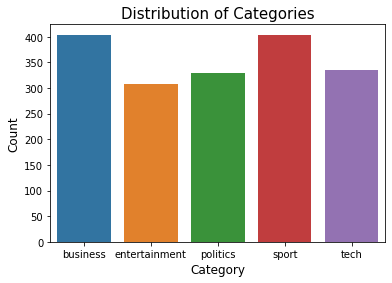

In [7]:
print(f"Number of documents in each category:\n\n{trainy.value_counts()}")

sns.countplot(x = trainy)
plt.title("Distribution of Categories", fontsize = 15)
plt.xlabel("Category", fontsize = 12)
plt.ylabel("Count", fontsize = 12)
plt.show()

# Classification

## Naive Bayes Classifier

In the Naive Bayes classifier below, the `CountVectorizer()` was used instead of the `TfidfVectorizer()`. This is because doing the two gave the same accuracy so using any of them is okay. Also note that removing stop words did not improve the model's accuracy in anyway on the training set but it did slightly improve the accuracy on the test set, hence stop words were removed. 


The model's accuracy on both the test set and training set are reported below. Also, classification reports on both test and training set are reported; this comes with extra metrics such as precision and recall but we will not explain them here since they are not the main focus of this assignment but we might make reference to them later in this notebook if there is a need for that. 

In the output below, we recorded a train set accuracy of 99.9438% and a test set accuracy of 97.5281%.

In [8]:
bayes_pipe = Pipeline([
    ("word_count", CountVectorizer(stop_words="english", 
                                  ngram_range = (1,2))),
    ("classify", MultinomialNB())
])


naive_bayes_clf = bayes_pipe.fit(trainX["text"], trainy)

print("Train set accuracy:", naive_bayes_clf.score(trainX["text"], trainy))
print("Test set accuracy:", naive_bayes_clf.score(testX["text"], testy))


print('\n\nTrain Set Classification Report: \n', classification_report(trainy, 
                                                         naive_bayes_clf.predict(trainX["text"]), 
                                                         digits=4))

print('\n\nTest Set Classification Report: \n', classification_report(testy, 
                                                         naive_bayes_clf.predict(testX["text"]), 
                                                         digits=4))

Train set accuracy: 0.999438202247191
Test set accuracy: 0.9752808988764045


Train Set Classification Report: 
                precision    recall  f1-score   support

     business     1.0000    0.9975    0.9988       404
entertainment     1.0000    1.0000    1.0000       307
     politics     0.9970    1.0000    0.9985       330
        sport     1.0000    1.0000    1.0000       404
         tech     1.0000    1.0000    1.0000       335

     accuracy                         0.9994      1780
    macro avg     0.9994    0.9995    0.9994      1780
 weighted avg     0.9994    0.9994    0.9994      1780



Test Set Classification Report: 
                precision    recall  f1-score   support

     business     0.9806    0.9528    0.9665       106
entertainment     1.0000    0.9620    0.9806        79
     politics     0.9551    0.9770    0.9659        87
        sport     1.0000    0.9907    0.9953       107
         tech     0.9296    1.0000    0.9635        66

     accuracy        

### Confusion Matrix

The output of the code is a confusion matrix for the Naive Bayes Classifier. This shows how the model correctly predicts files from the various classes/categories we have. Note that values along the leading diagonal are the correct classifications while values that are off the leading diagonal are misclassified. Hence, an ideal confusion matrix is the one with values only along the leading diagonal and everywhere else having zero values.

This means from the cofusion matrix below, the Naive Bayes classifier is doing a great job classifying the files. Note that, the confusion matrix is based on the test set.

Confusion matrix, without normalization


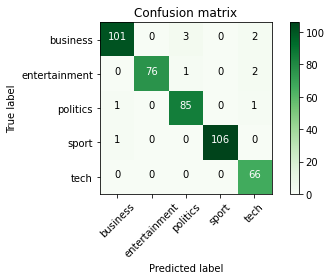

In [9]:
preds = naive_bayes_clf.predict(testX["text"])
cm = confusion_matrix(testy, preds)


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Greens):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
#     import itertools
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

#     print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

cnf_matrix = confusion_matrix(testy, preds)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=["business", 
                                           "entertainment", 
                                           "politics", 
                                           "sport", 
                                           "tech"],
                      #title='Confusion matrix, without normalization'
                     title='Confusion matrix')


/Users/titus/miniforge3/envs/mlp/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:999: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/Users/titus/miniforge3/envs/mlp/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:999: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/Users/titus/miniforge3/envs/mlp/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:999: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/Users/titus/miniforge3/envs/mlp/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:999: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/Users/titus/miniforge3/envs/mlp/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:999: UndefinedMetricWarning: No positive samples in y_true, true positive value

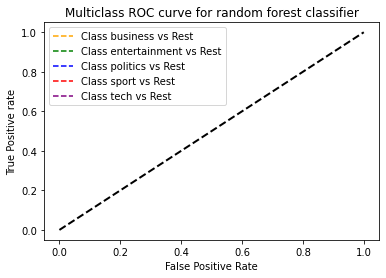

In [10]:
# multi-class classification
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt

# fit model
clf = OneVsRestClassifier(bayes_pipe)
clf.fit(trainX["text"], trainy)
pred = clf.predict(testX["text"])
pred_prob = clf.predict_proba(testX["text"])

# roc curve for classes
fpr = {}
tpr = {}
thresh ={}

n_class = 5

for i in range(n_class):    
    fpr[i], tpr[i], thresh[i] = roc_curve(testy, pred_prob[:,i], pos_label=i)
    
# plotting    
plt.plot(fpr[0], tpr[0], linestyle='--',color='orange', label='Class business vs Rest')
plt.plot(fpr[1], tpr[1], linestyle='--',color='green', label='Class entertainment vs Rest')
plt.plot(fpr[2], tpr[2], linestyle='--',color='blue', label='Class politics vs Rest')
plt.plot(fpr[3], tpr[3], linestyle='--',color='red', label='Class sport vs Rest')
plt.plot(fpr[4], tpr[4], linestyle='--',color='purple', label='Class tech vs Rest')


plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.title('Multiclass ROC curve for random forest classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='best')
#plt.savefig('Multiclass ROC',dpi=300);
plt.show()

## k-NN Classifier

**Note that, for the rest of the classifiers in this notebook, removing stop words improved their accuracy. Hence, stop words were removed from all of them. Also, unlike Naive Bayes classifier the `TfidfVectorizer()` was used instead of the `CountVectorizer()` because `TfidfVectorizer()` gives a better accuracy than `CountVectorizer()` in all the remaining classifiers in this notebook.**

The k-NN model with 5 nearest neighbours is shown below. The model's accuracy on both train and test sets are good (above 90%). However, comparing the accuracies alone shows that the Naive Bayes classifier is better than the k-NN classifier with 5 nearest neighbours. 

The classification reports for both the training and test set are also reported as shown below. 


In [11]:
knn_pipe1 = Pipeline([
    ("tfidf", TfidfVectorizer(stop_words="english", 
                              ngram_range = (1,5),
                              lowercase=True, max_features=10000)),
    ("classify", KNeighborsClassifier(n_neighbors=5))
])

knn_clf = knn_pipe1.fit(trainX["text"], trainy)

print("Train set accuracy:", knn_clf.score(trainX["text"], trainy))
print("Test set accuracy:", knn_clf.score(testX["text"], testy))

print('\n\nTrain Set Classification Report: \n', classification_report(trainy, 
                                                         knn_clf.predict(trainX["text"]), 
                                                         digits=4))

print('\n\nTest Set Classification Report: \n', classification_report(testy, 
                                                         knn_clf.predict(testX["text"]), 
                                                         digits=4))

Train set accuracy: 0.9685393258426966
Test set accuracy: 0.952808988764045


Train Set Classification Report: 
                precision    recall  f1-score   support

     business     0.9672    0.9480    0.9575       404
entertainment     0.9801    0.9642    0.9721       307
     politics     0.9474    0.9818    0.9643       330
        sport     0.9901    0.9950    0.9926       404
         tech     0.9551    0.9522    0.9537       335

     accuracy                         0.9685      1780
    macro avg     0.9680    0.9683    0.9680      1780
 weighted avg     0.9687    0.9685    0.9685      1780



Test Set Classification Report: 
                precision    recall  f1-score   support

     business     0.9327    0.9151    0.9238       106
entertainment     0.9500    0.9620    0.9560        79
     politics     0.9535    0.9425    0.9480        87
        sport     0.9811    0.9720    0.9765       107
         tech     0.9420    0.9848    0.9630        66

     accuracy        

### Confusion Matrix

The confusion matrix below also shows that the Naive Bayes classifier is doing better in classifying the test data than the k-NN model with 5 nearest neighbours. For instance, Naive Bayes classifier classified the `business`, `sport` and `tech` classes better than the k-NN classifier.

Confusion matrix, without normalization


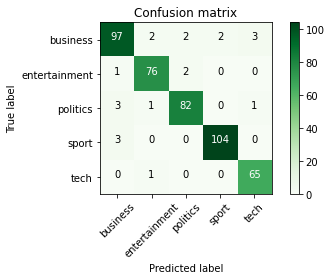

In [12]:
preds1 = knn_clf.predict(testX["text"])
cm1 = confusion_matrix(testy, preds1)


def plot_confusion_matrix(cm1, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Greens):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
#     import itertools
    if normalize:
        cm1 = cm1.astype('float') / cm1.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

#     print(cm)

    plt.imshow(cm1, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm1.max() / 2.
    for i, j in itertools.product(range(cm1.shape[0]), range(cm1.shape[1])):
        plt.text(j, i, format(cm1[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm1[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

cnf_matrix1 = confusion_matrix(testy, preds1)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix1, classes=["business", 
                                           "entertainment", 
                                           "politics", 
                                           "sport", 
                                           "tech"],
                      #title='Confusion matrix, without normalization'
                     title='Confusion matrix')


## k-NN with GridSearchCV

This time we fit the k-NN model using `GridSearchCV()` with a 5 fold cross-validation. However, the main focus of this example is to use `GridSearchCV()` to find the optimal nearest neighbours for the k-NN classifier using the accuracy as the objective function. Note that this time the optimal nearest neighbours is 10 for this classifier.

Note that the Naive Bayes classifier is still better than the k-NN classifier with `GridSearchCV()` in terms of the accuracy on both the training and test set. However, the performance of the k-NN classifier with `GridSearchCV()` is slightly better on the test set than the simple k-NN model with 5 nearest neighbours.

In [13]:
knn_pipe_grid = Pipeline(
    steps=[
    ("tfidf", TfidfVectorizer(stop_words="english", 
                              ngram_range = (1,5),
                              lowercase=True, max_features=10000)),
    ("classify", GridSearchCV(KNeighborsClassifier(), cv = 5,
                             param_grid = {
                                 "n_neighbors": range(1, 15)#[1, 2, 3, 5, 6, 7, 8, 9, 
                                                 #10,  11, 12, 13, 14, 15]
                             }, n_jobs=8, scoring=make_scorer(accuracy_score)))
])


knn_grid_clf = knn_pipe_grid.fit(trainX["text"], trainy)

print("Train set accuracy:", knn_grid_clf.score(trainX["text"], trainy))
print("Test set accuracy:", knn_grid_clf.score(testX["text"], testy))


print('\n\nTrain Set Classification Report: \n', classification_report(trainy, 
                                                         knn_grid_clf.predict(trainX["text"]), 
                                                         digits=4))

print('\n\nTest Set Classification Report: \n', classification_report(testy, 
                                                         knn_grid_clf.predict(testX["text"]), 
                                                         digits=4))

Train set accuracy: 0.9662921348314607
Test set accuracy: 0.9617977528089887


Train Set Classification Report: 
                precision    recall  f1-score   support

     business     0.9665    0.9282    0.9470       404
entertainment     0.9734    0.9544    0.9638       307
     politics     0.9368    0.9879    0.9617       330
        sport     0.9926    0.9975    0.9951       404
         tech     0.9585    0.9642    0.9613       335

     accuracy                         0.9663      1780
    macro avg     0.9656    0.9664    0.9658      1780
 weighted avg     0.9666    0.9663    0.9662      1780



Test Set Classification Report: 
                precision    recall  f1-score   support

     business     0.9510    0.9151    0.9327       106
entertainment     0.9872    0.9747    0.9809        79
     politics     0.9659    0.9770    0.9714        87
        sport     0.9811    0.9720    0.9765       107
         tech     0.9155    0.9848    0.9489        66

     accuracy       

In [14]:
knn_grid_clf.named_steps["classify"].best_params_

{'n_neighbors': 10}

### Confusion Matrix

Again, the confusion matrix below shows that the Naive Bayes classifier is better in classifying the test set than the k-NN model with `GridSearchCV()`. However, the k-NN classifier with `GridSearchCV()` is also slightly better than the simple k-NN model with 5 nearest neighbours. For instance the k-NN model with `GridSearchCV()` classifies the `entertainment` and `politics` classes better than the simple k-NN model with 5 nearest neighbours.

Confusion matrix, without normalization


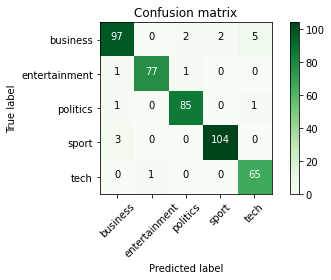

In [15]:
preds2 = knn_grid_clf.predict(testX["text"])
cm2 = confusion_matrix(testy, preds2)


def plot_confusion_matrix(cm2, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Greens):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
#     import itertools
    if normalize:
        cm2 = cm2.astype('float') / cm2.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

#     print(cm)

    plt.imshow(cm2, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm2.max() / 2.
    for i, j in itertools.product(range(cm2.shape[0]), range(cm2.shape[1])):
        plt.text(j, i, format(cm2[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm2[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

cnf_matrix2 = confusion_matrix(testy, preds2)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix2, classes=["business", 
                                           "entertainment", 
                                           "politics", 
                                           "sport", 
                                           "tech"],
                      #title='Confusion matrix, without normalization'
                     title='Confusion matrix')


In [16]:
# plt.plot(range(1,15), knn_grid_clf.cv_results_['mean_test_score'])
# plt.xlabel('Neighbors')
# plt.ylabel('CV Accuray')
# plt.title('5-fold CV')

# Dimensionality Reduction

This time we perform a dimensionality reduction on the data, we will retain the first 8 Principal Components (PCs). We transform the results and then convert into a data frame. The pipeline below helps to achieve this. 

In [17]:
svd_pipe = Pipeline([
    ('word_vec', TfidfVectorizer(stop_words="english", 
                                 ngram_range = (1,5),
                                lowercase=True, max_features=10000)),
    ('svd', TruncatedSVD(8, random_state=1))
])


svd_pipe1 = svd_pipe.fit(trainX['text'])

#svd_pipe.fit(trainX['text'])

text_vectors = svd_pipe1.transform(trainX['text'])
text_vectors1 = pd.DataFrame(text_vectors)
text_vectors1 = pd.concat([pd.DataFrame(trainy).reset_index().drop(columns=["index"]), 
                           text_vectors1], axis=1)
text_vectors1["category"] = text_vectors1["category"].astype("category")
text_vectors1.columns = ["category", "PC1", "PC2", "PC3", "PC4", 
                         "PC5", "PC6", "PC7", "PC8"]
text_vectors1.head()

,category,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8
0,business,0.130374,0.002485,0.054931,-0.040047,0.073038,0.005635,-0.010639,-0.045098
1,politics,0.199302,0.082953,0.012561,-0.016150,0.014339,0.047730,-0.004764,-0.092011
2,tech,0.119897,-0.039394,0.125766,-0.004365,-0.118728,0.077251,0.010873,-0.178055
3,sport,0.081724,-0.077122,-0.119502,-0.082614,0.004285,-0.027714,-0.105395,0.007782
4,politics,0.126463,0.060126,-0.024276,0.002013,-0.016656,0.047820,0.022424,-0.056014


## Paired Plot of Reduced Dimensions

Below is a paired plot of the 8 principal components. Here we notice that the principal components have overlapping classes. Also, decision boundaries for the principal components are non-linear.

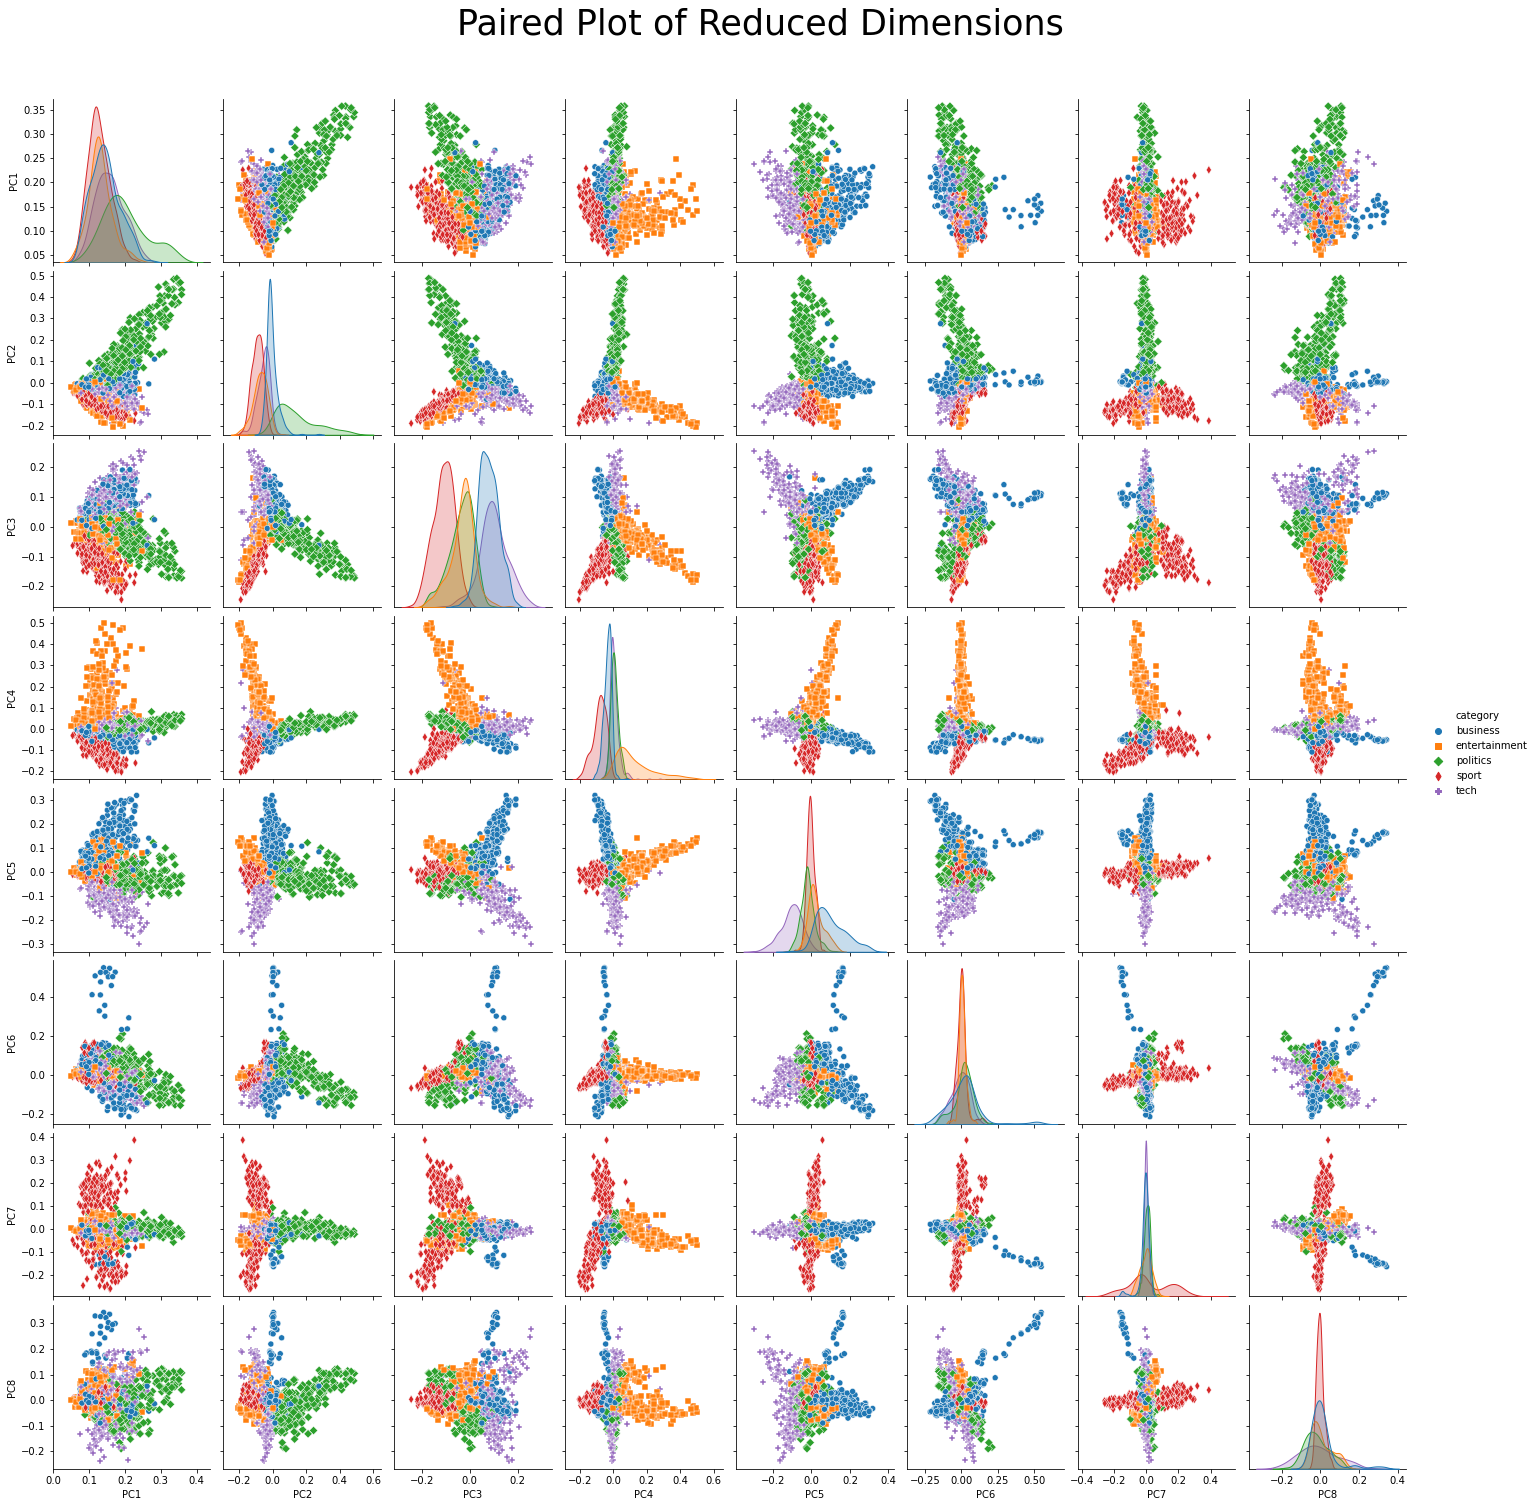

In [18]:
sns.pairplot(text_vectors1, hue="category", markers=["o", "s", "D", "d", "P"])
#sns.pairplot(text_vectors1, hue="category", kind="kde", markers=["o", "s", "D", "p", "H"])
plt.suptitle("Paired Plot of Reduced Dimensions", 
             fontsize = 35, y = 1.05)

plt.xticks(fontsize = 20)
plt.xticks(fontsize = 20)
plt.show()

## k-NN Classifier on the Reduced Dimensions

This time the Naive Bayes classifier is still better than the k-NN classifier with reduced dimensions in terms of their accuracy on both the training and test sets. However, the k-NN model with reduced dimensions is also slightly better than the previous two k-NN models in terms of the accuracy on both the training and test sets.

Also note that, this time the optimal number of nearest neighbours is 3.

The output is shown below.

In [19]:
# svd_pipe2 = svd_pipe.fit(testX['text'])

# #svd_pipe.fit(trainX['text'])

# text_vectors2 = svd_pipe2.transform(testX['text'])
# #text_vectors2

In [20]:
# text_vectors21 = pd.DataFrame(text_vectors2)
# text_vectors21 = pd.concat([pd.DataFrame(testy).reset_index().drop(columns=["index"]), 
#                            text_vectors21], axis=1)
# text_vectors21["category"] = text_vectors21["category"].astype("category")
# text_vectors21.columns = ["category", "PC1", "PC2", "PC3", "PC4", 
#                          "PC5", "PC6", "PC7", "PC8"]
# text_vectors21.head()

In [21]:
# knn_pipe_svd = Pipeline([
#     #("tfidf", svd_pipe),
#     ("classify", KNeighborsClassifier(n_neighbors=5))
# ])

# knn_svd_clf = knn_pipe_svd.fit(text_vectors1.drop(columns = ["category"]), 
#                                text_vectors1["category"])

# print("Train set accuracy:", knn_svd_clf.score(text_vectors1.drop(columns = ["category"]), 
#                                            text_vectors1["category"]))

# print("Test set accuracy:", knn_svd_clf.score(text_vectors21.drop(columns = ["category"]), 
#                                           text_vectors21["category"]))

In [22]:
svd_knn_inner = Pipeline([
    ('latent', TruncatedSVD(8, random_state=0)),
    ('class', KNeighborsClassifier())
])
svd_knn = Pipeline([
    ("vectorize", TfidfVectorizer(stop_words="english", 
                                  lowercase=True, 
                                  ngram_range = (1,2), 
                                  max_features=10000)),
    ("class", RandomizedSearchCV(svd_knn_inner, param_distributions={
        #"latent__n_components": stats.randint(1, 50),
        "class__n_neighbors": stats.randint(1, 25)
    }, n_iter=60, n_jobs=8, random_state=0))
])
knn_svd_clf = svd_knn.fit(trainX["text"], trainy)



print("Train set accuracy:", knn_svd_clf.score(trainX["text"], trainy))
print("Test set accuracy:", knn_svd_clf.score(testX["text"], testy))


print('\n\nTrain Set Classification Report: \n', classification_report(trainy, 
                                                         knn_svd_clf.predict(trainX["text"]), 
                                                         digits=4))

print('\n\nTest Set Classification Report: \n', classification_report(testy, 
                                                         knn_svd_clf.predict(testX["text"]), 
                                                         digits=4))

Train set accuracy: 0.9792134831460674
Test set accuracy: 0.9640449438202248


Train Set Classification Report: 
                precision    recall  f1-score   support

     business     0.9725    0.9629    0.9677       404
entertainment     0.9805    0.9805    0.9805       307
     politics     0.9699    0.9758    0.9728       330
        sport     1.0000    0.9975    0.9988       404
         tech     0.9704    0.9791    0.9747       335

     accuracy                         0.9792      1780
    macro avg     0.9786    0.9791    0.9789      1780
 weighted avg     0.9792    0.9792    0.9792      1780



Test Set Classification Report: 
                precision    recall  f1-score   support

     business     0.9528    0.9528    0.9528       106
entertainment     0.9634    1.0000    0.9814        79
     politics     0.9759    0.9310    0.9529        87
        sport     0.9815    0.9907    0.9860       107
         tech     0.9394    0.9394    0.9394        66

     accuracy       

In [23]:
knn_svd_clf['class'].best_params_

{'class__n_neighbors': 3}

### Confusion Matrix

The output of the code below is the confusion matrix of the k-NN classifier with SVD. It looks similar to the previous two k-NN classifiers, but overall, this classifier is better than the previous two k-NN classifiers.

Confusion matrix, without normalization


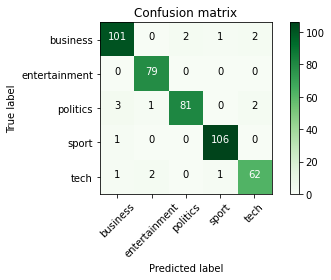

In [24]:
preds3 = knn_svd_clf.predict(testX["text"])
cm3 = confusion_matrix(testy, preds3)


def plot_confusion_matrix(cm3, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Greens):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
#     import itertools
    if normalize:
        cm3 = cm3.astype('float') / cm3.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

#     print(cm)

    plt.imshow(cm3, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm3.max() / 2.
    for i, j in itertools.product(range(cm3.shape[0]), range(cm3.shape[1])):
        plt.text(j, i, format(cm3[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm3[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

cnf_matrix3 = confusion_matrix(testy, preds3)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix3, classes=["business", 
                                           "entertainment", 
                                           "politics", 
                                           "sport", 
                                           "tech"],
                      #title='Confusion matrix, without normalization'
                     title='Confusion matrix')


# Summarizing Classifier Accuracy

## Accuracy of the 4 Different Classifiers

Here we summarize the accuracy of all the classifers so far and then plot them as a line plot.

From the line plot below, Naive Bayes classifier is the best model because it has the best (highest) accuracy on the test set.

Also, the same Naive Bayes classifier seems to be overfitting because it has the highest difference between the train and test accuracy.

In [25]:
num_models = 4

train_accuracy = np.zeros(num_models)
test_accuracy = np.zeros(num_models)


models = [naive_bayes_clf, knn_clf, knn_grid_clf, knn_svd_clf]
exception = [knn_svd_clf]
models_names = ["Naive_Bayes", "k_NN", "k_NN2", "k_NN_PCA"]

for i in range(len(models)):
#     if models[i] not in exception:
    pred_train = models[i].predict(trainX['text'])
    pred_test = models[i].predict(testX['text'])
    train_accuracy[i] = accuracy_score(trainy, pred_train)
    test_accuracy[i] = accuracy_score(testy, pred_test)
#     else:
#         pred_train = models[i].predict(text_vectors1.drop(columns = ["category"]))
#         pred_test = models[i].predict(text_vectors21.drop(columns = ["category"]))
#         train_accuracy[i] = accuracy_score(text_vectors1["category"], pred_train)
#         test_accuracy[i] = accuracy_score(text_vectors21["category"], pred_test)
    
model_metrics = pd.DataFrame({'Model': models_names ,
                              'Train_Accuracy': train_accuracy,
                              'Test_Accuracy': test_accuracy})

model_metrics["Optimism"] = model_metrics["Train_Accuracy"] \
- model_metrics["Test_Accuracy"]

model_metrics

,Model,Train_Accuracy,Test_Accuracy,Optimism
0,Naive_Bayes,0.999438,0.975281,0.024157
1,k_NN,0.968539,0.952809,0.015730
2,k_NN2,0.966292,0.961798,0.004494
3,k_NN_PCA,0.979213,0.964045,0.015169


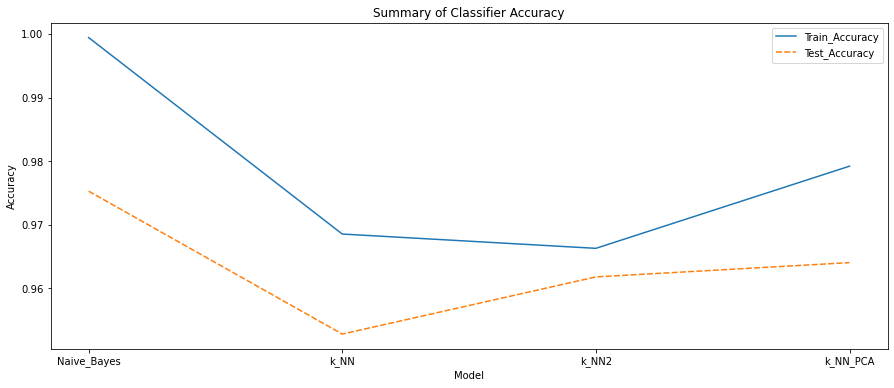

In [26]:
plt.figure(figsize=(15,6))
sns.lineplot(data=model_metrics.drop(columns = ["Optimism"]))
plt.title("Summary of Classifier Accuracy")
plt.xlabel("Model")
plt.ylabel("Accuracy")
plt.xticks(np.arange(4), ["Naive_Bayes", "k_NN", "k_NN2", 
                         "k_NN_PCA"])
plt.show()

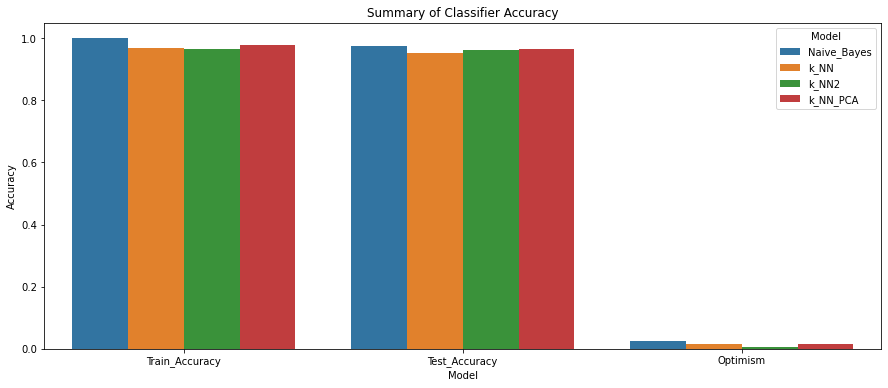

In [27]:
temp_df = model_metrics.melt(id_vars='Model')
# temp_df
plt.figure(figsize=(15,6))
sns.barplot(x = 'variable', y='value', hue='Model', data=temp_df)
plt.title("Summary of Classifier Accuracy")
plt.xlabel("Model")
plt.ylabel("Accuracy")
plt.show()

## GridSearchCV for the SVD

This time we will use `GridSearchCV()` to simultaneously pick a good number of dimensions for the SVD and a good number of neighbours.

Again, the Naive Bayes classifier looks better than this model considering the accuracy on both the test and training sets. The best number of Principal Components (PCs) is 15 while the optimal number of nearest neighbours is 11 as shown below. 

The classification report on both the train and test sets is also shown below.

In [28]:
svd_knn_inner = Pipeline([
    ('latent', TruncatedSVD(random_state=50)),
    ('class', KNeighborsClassifier(algorithm = "kd_tree", 
                                  leaf_size = 10))
])
svd_bayes_knn = Pipeline([
    ('vectorize', TfidfVectorizer(stop_words="english", 
                                  ngram_range = (1,2)
                                 )),
    ('class', GridSearchCV(svd_knn_inner, {
        'latent__n_components': (1, 15),
        'class__n_neighbors': (2, 11)
    }, cv = 5))
])

knn_grid_svd_clf = svd_bayes_knn.fit(trainX["text"], trainy)
print("Train set accuracy:", knn_grid_svd_clf.score(trainX["text"], trainy))
print("Test set accuracy:", knn_grid_svd_clf.score(testX["text"], testy))

print('\n\nTrain Set Classification Report: \n', classification_report(trainy, 
                                                         knn_grid_svd_clf.predict(trainX["text"]), 
                                                         digits=4))

print('\n\nTest Set Classification Report: \n', classification_report(testy, 
                                                         knn_grid_svd_clf.predict(testX["text"]), 
                                                         digits=4))

Train set accuracy: 0.9674157303370786
Test set accuracy: 0.9617977528089887


Train Set Classification Report: 
                precision    recall  f1-score   support

     business     0.9526    0.9455    0.9491       404
entertainment     0.9465    0.9805    0.9632       307
     politics     0.9635    0.9606    0.9621       330
        sport     0.9926    0.9975    0.9951       404
         tech     0.9785    0.9522    0.9652       335

     accuracy                         0.9674      1780
    macro avg     0.9668    0.9673    0.9669      1780
 weighted avg     0.9675    0.9674    0.9674      1780



Test Set Classification Report: 
                precision    recall  f1-score   support

     business     0.9703    0.9245    0.9469       106
entertainment     0.9747    0.9747    0.9747        79
     politics     0.9444    0.9770    0.9605        87
        sport     0.9727    1.0000    0.9862       107
         tech     0.9385    0.9242    0.9313        66

     accuracy       

In [29]:
knn_grid_svd_clf['class'].best_params_

{'class__n_neighbors': 11, 'latent__n_components': 15}

### Confusion Matrix

The confusion matrix for the immediate model above is shown below. Note that particularly, this model classifies the `sport` class better than all the classifiers fitted so far in this notebook. However, this model also classifies the `tech` class in the test set worse than any of the classifier fitted so far.

Confusion matrix, without normalization


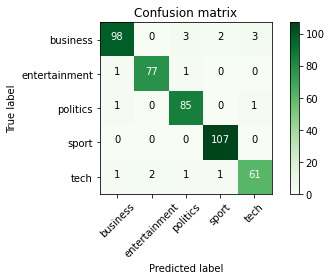

In [30]:
preds4 = knn_grid_svd_clf.predict(testX["text"])
cm4 = confusion_matrix(testy, preds4)


def plot_confusion_matrix(cm4, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Greens):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
#     import itertools
    if normalize:
        cm4 = cm4.astype('float') / cm4.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

#     print(cm)

    plt.imshow(cm4, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm4.max() / 2.
    for i, j in itertools.product(range(cm4.shape[0]), range(cm4.shape[1])):
        plt.text(j, i, format(cm4[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm4[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

cnf_matrix4 = confusion_matrix(testy, preds4)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix4, classes=["business", 
                                           "entertainment", 
                                           "politics", 
                                           "sport", 
                                           "tech"],
                      #title='Confusion matrix, without normalization'
                     title='Confusion matrix')


# Clustering

Here we are going to use the entire data set since clustering algorithm are unsupervised learning algorithms. There are no labelled classes that we are trying to predict. Thus, there is no target variable we are trying to predict here.

## k-Means Model With 5 Clusters

Below we perform the k-means clustering with 5 clusters.

In [31]:
cluster_pipe = Pipeline(steps=[('vectorize',
                 TfidfVectorizer(ngram_range = (1,2),
                                 stop_words='english')),
                ('cluster', KMeans(n_clusters=5, random_state=200))])

cluster_pipe1 = cluster_pipe.fit(articles['text'])
paper_clusters = cluster_pipe1.predict(articles['text'])

In [32]:
# c1_ = articles.loc[paper_clusters == 0, 'category']
# c1 = pd.DataFrame(pd.Series('Cluster 1', index=c1_.index), 
#                   columns = ['cluster'])

# c2_ = articles.loc[paper_clusters == 1, 'category']
# c2 = pd.DataFrame(pd.Series('Cluster 2', index=c2_.index), 
#                   columns = ['cluster'])

# c3_ = articles.loc[paper_clusters == 2, 'category']
# c3 = pd.DataFrame(pd.Series('Cluster 3', index=c3_.index), 
#                   columns = ['cluster'])

# c4_ = articles.loc[paper_clusters == 3, 'category']
# c4 = pd.DataFrame(pd.Series('Cluster 4', index=c4_.index), 
#                   columns = ['cluster'])

# c5_ = articles.loc[paper_clusters == 4, 'category']
# c5 = pd.DataFrame(pd.Series('Cluster 5', index=c5_.index), 
#                   columns = ['cluster'])

# cluster_df1 = pd.concat([c1, c2, c3, c4, c5]).sort_index(axis = 0)
# cluster_df1['category'] = articles['category']
# cluster_df1.head()

Here we prepare the data so that we can explore the distribution of document categories within each cluster. At the end the idea is to plot a faceted bar chart: one bar plot for each cluster, in which the x-axis is the article category, and the y-axis is the number of documents in that cluster that are in that category.

In [33]:
cluster1 = pd.DataFrame(pd.Series('1st', 
                       index=articles.loc[paper_clusters == 0, 
                                          'category'].index), 
             columns = ['cluster'])



cluster2 = pd.DataFrame(pd.Series('2nd', 
                       index=articles.loc[paper_clusters == 1, 
                                          'category'].index), 
             columns = ['cluster'])



cluster3 = pd.DataFrame(pd.Series('3rd', 
                       index=articles.loc[paper_clusters == 2, 
                                          'category'].index), 
             columns = ['cluster'])



cluster4 = pd.DataFrame(pd.Series('4th', 
                       index=articles.loc[paper_clusters == 3, 
                                          'category'].index), 
             columns = ['cluster'])



cluster5 = pd.DataFrame(pd.Series('5th', 
                       index=articles.loc[paper_clusters == 4, 
                                          'category'].index), 
             columns = ['cluster'])




dictionary1 = {"cluster": pd.concat([cluster1, 
           cluster2,cluster3, cluster4, 
           cluster5]).sort_index(axis = 0).values.tolist()}

cluster_data = pd.DataFrame(data = dictionary1)
cluster_data['category'] = articles['category']
cluster_data["cluster"] = cluster_data["cluster"].astype(str).replace({'\[': '', 
                                                                       '\]': '', 
                                                                       "'": ''}, 
                                                                      regex=True)

cluster_data.head()

,cluster,category
0,4th,entertainment
1,4th,entertainment
2,4th,entertainment
3,4th,entertainment
4,4th,entertainment


### Faceted Bar Plot

The k-means clustering did well in putting the documents into clusters. This is because the classes in our original target variable mostly belong to the same/distinct/unique clusters. Note that, here there are no labelled classes to predict but having documents from the same file category clustered in the same cluster or group makes much sense. Also note that cluster four has all the categories represented quite frequently compared to other clusters, however, the `entertainment` class far dominates the rest of the classes in that cluster (i.e. cluster 4). This means cluster 4 is still useful/important.

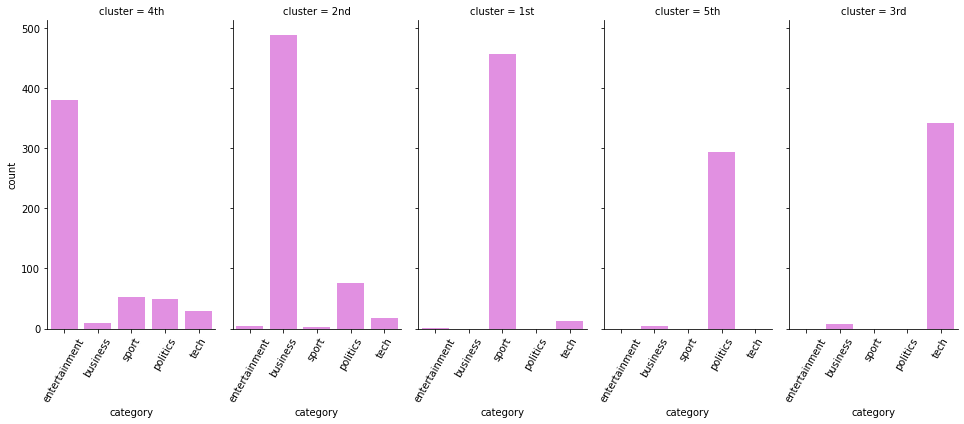

In [34]:
d = {'color': ['violet']}
plot = sns.FacetGrid(cluster_data, col="cluster", 
                     height=6, aspect=0.45, hue_kws=d)
plot.map(sns.countplot, "category", 
       order=cluster_data.category.unique())

for axes in plot.axes.flat:
    _ = axes.set_xticklabels(axes.get_xticklabels(), rotation=60)
plt.tight_layout()

## k-Means Model With 6 Clusters

Below we perform the k-means clustering with 6 clusters.

In [35]:
cluster_pipe2 = Pipeline(steps=[('vectorize',
                 TfidfVectorizer(ngram_range = (1,2),
                                 stop_words='english')),
                ('cluster', KMeans(n_clusters=6, random_state=200))])

cluster_pipe21 = cluster_pipe2.fit(articles['text'])
paper_clusters2 = cluster_pipe21.predict(articles['text'])

Again, here we prepare the data so that we can explore the distribution of document categories within each cluster. At the end the idea is to plot a faceted bar chart: one bar plot for each cluster, in which the x-axis is the article category, and the y-axis is the number of documents in that cluster that are in that category.

In [36]:
cluster11 = pd.DataFrame(pd.Series('1st', 
                       index=articles.loc[paper_clusters2 == 0, 
                                          'category'].index), 
             columns = ['cluster'])



cluster22 = pd.DataFrame(pd.Series('2nd', 
                       index=articles.loc[paper_clusters2 == 1, 
                                          'category'].index), 
             columns = ['cluster'])



cluster33 = pd.DataFrame(pd.Series('3rd', 
                       index=articles.loc[paper_clusters2 == 2, 
                                          'category'].index), 
             columns = ['cluster'])



cluster44 = pd.DataFrame(pd.Series('4th', 
                       index=articles.loc[paper_clusters2 == 3, 
                                          'category'].index), 
             columns = ['cluster'])



cluster55 = pd.DataFrame(pd.Series('5th', 
                       index=articles.loc[paper_clusters2 == 4, 
                                          'category'].index), 
             columns = ['cluster'])


cluster66 = pd.DataFrame(pd.Series('6th', 
                       index=articles.loc[paper_clusters2 == 5, 
                                          'category'].index), 
             columns = ['cluster'])


dictionary2 = {"cluster": pd.concat([cluster11, 
           cluster22, cluster33, cluster44, cluster55,
           cluster66]).sort_index(axis = 0).values.tolist()}

cluster_data2 = pd.DataFrame(data = dictionary2)
cluster_data2['category'] = articles['category']
cluster_data2["cluster"] = cluster_data2["cluster"].astype(str).replace({'\[': '', 
                                                                       '\]': '', 
                                                                       "'": ''}, 
                                                                      regex=True)

cluster_data2.head()

,cluster,category
0,6th,entertainment
1,1st,entertainment
2,1st,entertainment
3,1st,entertainment
4,1st,entertainment


### Faceted Bar Plot

This clustering looks quite good, however, it is worse compared to the previous k-means clustering with 5 clusters. In cluster 6 for example, the classes are quite not well distinguished; thus, even though the `business` class is the most dominant class in that cluster, other classes such as the `entertainment` and `politics` are also quite dominant in that cluster. This is not the case with the previous k-means clustering with 5 clusters. In the previous clustering algorithm with 5 clusters, the classes in our original target variable are well separated in each cluster than this current clustering algorithm with 6 clusters.

We can also notice that the `business` class is the most dominant class in both cluster 6 and cluster 2. This is not good because documents from the same class are clustered in two distinct clusters as the dominant class in those clusters. This also explains why the files are not well separated/distinguished in this current clustering algorithm with 6 clusters.

In conclusion, the previous clustering algorithm with 5 clusters is better than this current one with 6 clusters.

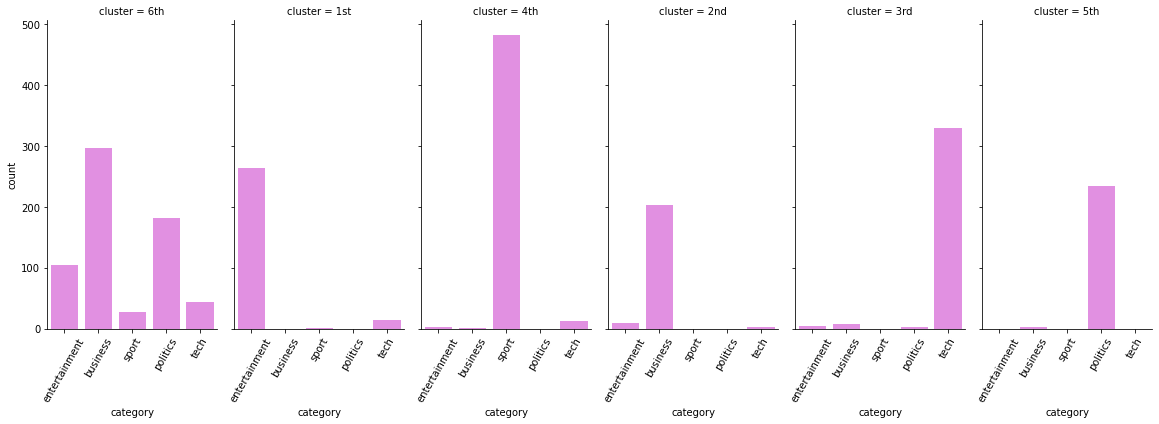

In [37]:
d = {'color': ['violet']}
plot2 = sns.FacetGrid(cluster_data2, col="cluster", 
                     height=6, aspect=0.45, hue_kws=d)
plot2.map(sns.countplot, "category", 
       order=cluster_data2.category.unique())

for axes in plot2.axes.flat:
    _ = axes.set_xticklabels(axes.get_xticklabels(), rotation=60)
plt.tight_layout()

### Finding Most Important Words

As already stated, the clustering algorithm with 5 clusters is better than the one with 6 clusters. Hence, we will use the clustering algorithm with 5 clusters here.

In [38]:
cluster_centers = cluster_pipe1.named_steps.cluster.cluster_centers_
important_words = cluster_pipe.named_steps.vectorize.get_feature_names_out()

center1 = important_words[np.where(cluster_centers[0, :] == \
                               list(np.amax(cluster_centers, 
                                            axis=1))[0])[0][0]]


center2 = important_words[np.where(cluster_centers[1, :] == \
                               list(np.amax(cluster_centers, 
                                            axis=1))[1])[0][0]]


center3 = important_words[np.where(cluster_centers[2, :] == \
                               list(np.amax(cluster_centers, 
                                            axis=1))[2])[0][0]]


center4 = important_words[np.where(cluster_centers[3, :] == \
                               list(np.amax(cluster_centers, 
                                            axis=1))[3])[0][0]]


center5 = important_words[np.where(cluster_centers[4, :] == \
                               list(np.amax(cluster_centers, 
                                            axis=1))[4])[0][0]]

cl_num = ['cluster1', 'cluster2', 'cluster3', 'cluster4', 'cluster5']

centers_df = [center1, center2, center3, center4, center5]

important_words_output = pd.concat([pd.DataFrame({"cluster":cl_num}), 
                                    pd.DataFrame({"important_word":centers_df})], 
                                   axis=1)

print("\n\nMost important words in each cluster")
important_words_output



Most important words in each cluster


,cluster,important_word
0,cluster1,game
1,cluster2,said
2,cluster3,mobile
3,cluster4,film
4,cluster5,mr


Note that in the k-means clustering with 5 clusters, the following classes are the most dominant classes in the various clusters:

1. cluster 1 = sports
2. cluster 2 = business
3. cluster 3 = tech
4. cluster 4 = entertainment
5. cluster 5 = politics

If we take these dominant classes as the clusters classess, then, based on this information, we can say that it makes much sense for the words `game`, `mobile` and `film` to be the most important words in `sports` (i.e. cluster 1), `tech` (i.e. cluster 3) and `entertainment` (i.e. cluster 4) respectively. However, it sounds quite weird/unusual to have the words `said` and `mr` being the most important words in `business` (i.e. cluster 2) and `politics` (i.e. cluster 5) respectively; this is quite unexpected.

# Reflection

The first thing we learned in this assignment is a practical understanding of how to work with unsupervised learning techniques, specifically the k-means clustering algorithm. This kind of algortithm use unstructured data and this also gave us a good practical understanding about working with unstructured data. Unsupervised learning techniques as well as working with unstructured data is something that is unusual to us because we are usually exposed to tabular data.


In this assignment we also learned that stop words can have a significant impact on text classification models. Thus, for text classification models, removing stop words could be a feasible way to increase your classification model's accuracy. This is because, for text classification, words that are unique to the documnents are most important in classifying them than stop words since stop words are generally common words that can be found in almost all the documents, hence, they do not contribute much in classifying the documents. For instance, in this assignment, for each of the classifiers, removing stop words improved the classifer's accuracy in one way or the other. Also, n-grams can also influence a text classification model's accuracy. For instance, in this assignment tokenizing the documents into bi-grams (i.e. n-grams = 2) actually also improved the accuracy of the classifiers than just tokenizing them into single words (i.e. n-gram = 1). This is something fascinating we learned in this assignment.


On a final note,another fascinating aspect of this assignment is being able to perform dimensionality reduction on text data. We are familiar with dimensionality reduction techniques such as Principal Component Analysis (PCA) but we have never seen them being applied on text data hitherto. However, in this assignment we practically implemented dimensionality reduction techniques on text data by ourselves. This is something we are elated we learned in this assignment.